In [1]:
# Processing/Misc

from sklearn.utils import shuffle

import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
# Keras

import keras.backend as K
from keras import regularizers
from keras.optimizers import adam, Nadam
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, Conv2D, BatchNormalization, Activation, GlobalMaxPooling1D, MaxPooling1D, TimeDistributed

Using TensorFlow backend.


In [3]:
# Hyperz

epochs           = 600
batch_size       = 32

window_size      = 50
skip_window_size = 6

train_split      = .9
emb_size         = 5

In [4]:
# Load Data

def create_timeframed_alldata_data(stocks, window_size=10, skip_window_size=2):
    """
    Timeframe Alldata
    
    Parameters
    ----------
    stocks : list `str`
        The names of the stocks to use (pulled by name from data dir)
    
    Returns
    -------
    X, Y : tuple `np.array`
        The X and Y data
    """
    X, Y = [], []
    
    for stock in stocks:
        
        ### Load From File
        
        raw_data = []
        
        with open(os.path.join('..', 'data', stock + '.csv'), 'r') as data:

            for line in data:

                if len(line) > 6 and "Date" not in line and "null" not in line:

                    items = line.split(",")
                    items = np.array(list(map(float, items[1:])))

                    raw_data.append(np.take(items, [0, 1, 2, 4, 5])) # OPEN HIGH LOW ADJ_CLOSE VOLUME
        
        data = np.array(raw_data)
        
        ### Process
        
        for i in range(1, len(data) - window_size - 1):

            time_frame = np.copy(data[i: i + window_size + 1]) # .copy so data[] not modified
            
            trainable_frame = time_frame[:-skip_window_size-1]

            time_frame -= np.mean(trainable_frame, axis=0) # Only normalized via trainable frame b/c thats all
            time_frame /= np.std(trainable_frame, axis=0)  #    you get at test time
            
            target_close = time_frame[-1, 3]
            last_close = trainable_frame[-1, 3]
            
            dclose = target_close - last_close
            dclose = dclose**2

            X.append(trainable_frame)
            
            if last_close < target_close:
                Y.append([1., 0., dclose]) # Predict: P(Stock Increased) P(Stock Decreased) +/-AmtChanged^2
            else:
                Y.append([0., 1., dclose])
            
    return np.array(X), np.array(Y)


In [5]:
# Split

def split_data(X, Y, ratio, mix=True):
    """
    Splits X/Y to Train/Test
    """
    
    if mix:
        
        X, Y = shuffle(X, Y, random_state=11)
        
    train_size = int(len(X) * ratio)
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    # print(np.std(trainY[:, 2]))
    # print(np.std(testY[:, 2]))
    
    return trainX, trainY, testX, testY

def get_data(stocks):
    
    X, Y = create_timeframed_alldata_data(stocks, window_size=window_size, skip_window_size=skip_window_size)
    
    Y[:, 2] /= 10. # Normalize stock changes (precomputed constant stddev)
    
    return split_data(X, Y, train_split)


In [6]:
# Model

def acc_metric(y_true, y_pred):
    """
    Accuracy
    
    Keras metric to compute the %accuracy of prediction price going up vs down
    """
    return K.mean(K.equal(y_true[:, 0] > y_true[:, 1], 
                          y_pred[:, 0] > y_pred[:, 1]), axis=-1) # Verify the signs aka up/downs are the same

def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def get_model():
    
    input_shape = (window_size - skip_window_size, emb_size)
    
    model = Sequential()

    model.add(Conv1D(64, 5, padding='same', input_shape=input_shape))
    model.add(PReLU())
    model.add(MaxPooling1D(pool_size=5))

    model.add(LSTM(300))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(300))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(300))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(300))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(3))
    
    model.compile(loss=mse_loss, optimizer=adam(lr=0.0012), metrics=[acc_metric])
        
    return model


In [7]:
# Load Data

if __name__ == "__main__":
    
    trainX, trainY, testX, testY = get_data(['GOOG', 'MSFT'])
    
    print(trainX.shape, testY.shape) # Manually Verify train size, general input dim and test size, general output dim


(10057, 44, 5) (1118, 3)


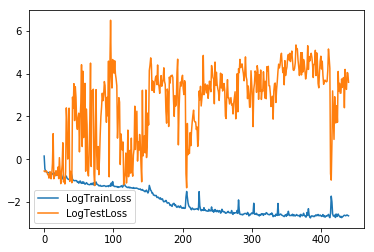

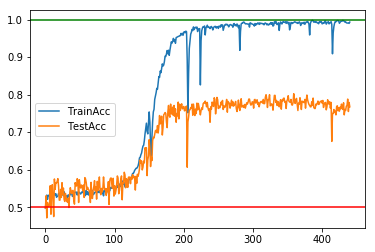

In [8]:
# Train

if __name__ == "__main__":

    model = get_model()

    reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=1e-7, verbose=0)
    e_stopping = EarlyStopping(monitor='val_acc_metric', patience=80)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'trend-pred.h5'), 
                                 monitor='val_acc_metric', 
                                 verbose=0,
                                 save_best_only=True)

    history = model.fit(trainX, trainY, epochs=epochs, 
                                        batch_size=batch_size, 
                                        validation_data=(testX, testY), 
                                        verbose=0, 
                                        callbacks=[e_stopping, checkpoint])

    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()

    plt.plot(history.history['acc_metric'])
    plt.plot(history.history['val_acc_metric'])
    plt.axhline(y=1, color='g')
    plt.axhline(y=0.5, color='r')
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
